In [88]:
import json, os
from dataclasses import dataclass
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import re

In [2]:
SAMPLE_DIR = "./sample-v2/api-10k-dump-tests"


# Price extraction

In [3]:
@dataclass
class PriceWithFileName:
    price: float
    name: str

prices_with_name = []
for file in os.listdir(SAMPLE_DIR):
    if file.endswith(".json"):
        with open(os.path.join(SAMPLE_DIR, file), 'r') as f:
            data = json.load(f)
            prices_with_name.append(PriceWithFileName(data['priceInChaos'], file))

In [4]:
prices = [price_with_name.price for price_with_name in prices_with_name]
price_series = pd.Series(prices)
price_series

0        30.0
1        50.0
2        80.0
3        50.0
4        15.0
         ... 
48802    15.0
48803    15.0
48804    25.0
48805    10.0
48806     5.0
Length: 48807, dtype: float64

# Price Distribution

In [5]:
price_series.describe()

count    4.880700e+04
mean     6.621080e+03
std      8.274049e+05
min      0.000000e+00
25%      1.000000e+01
50%      3.900000e+01
75%      1.331300e+02
max      1.766988e+08
dtype: float64

In [6]:
price_distribution = price_series.value_counts().sort_index()
price_distribution

0.000000e+00     2
6.000000e-02     6
8.000000e-02    11
1.100000e-01    15
1.400000e-01     1
                ..
1.768757e+05    18
3.537513e+05     1
1.061254e+06     1
1.768757e+07     7
1.766988e+08     1
Name: count, Length: 357, dtype: int64

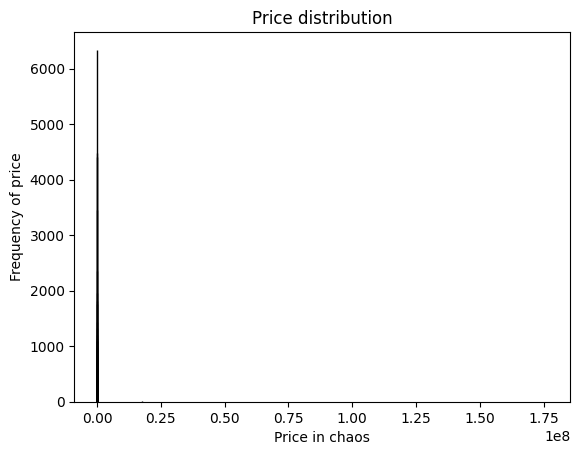

In [7]:
plt.bar(price_distribution.index, price_distribution.values, edgecolor='black')
plt.title("Price distribution")
plt.xlabel("Price in chaos")
plt.ylabel("Frequency of price")
plt.show()

<Axes: >

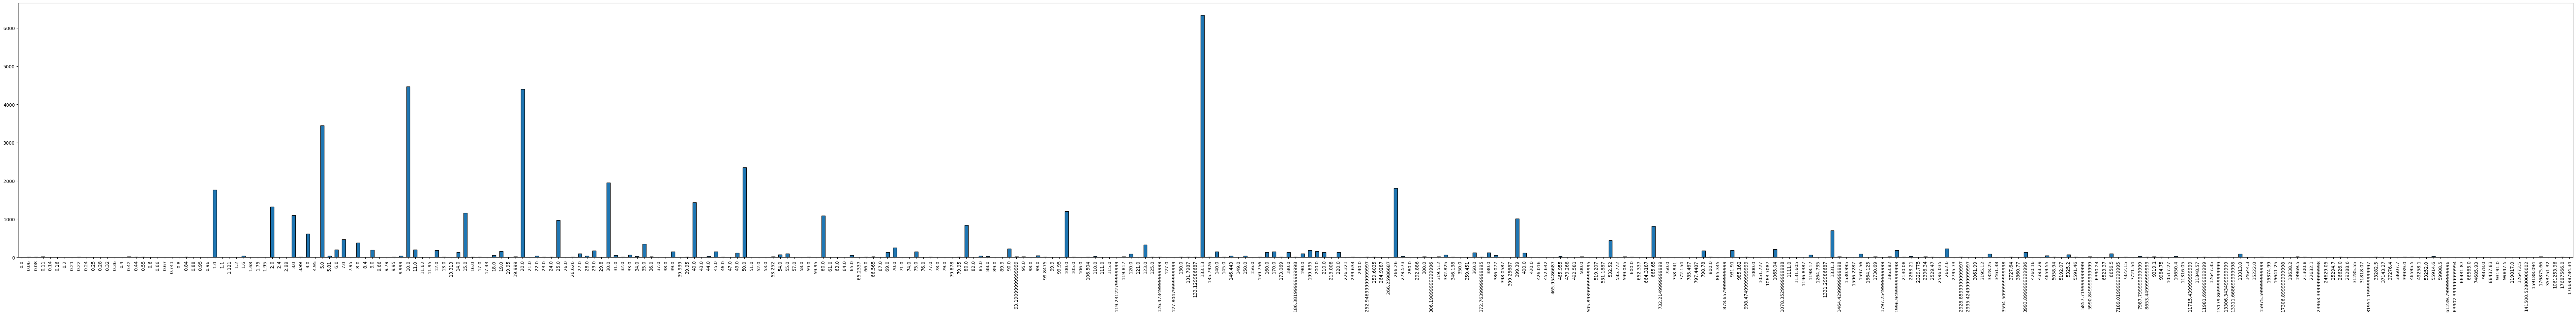

In [8]:
# not so readble, let's try with plot on pandas series directly
price_distribution.plot(kind='bar', logy=False, edgecolor='black', figsize=(100, 10))

<Axes: >

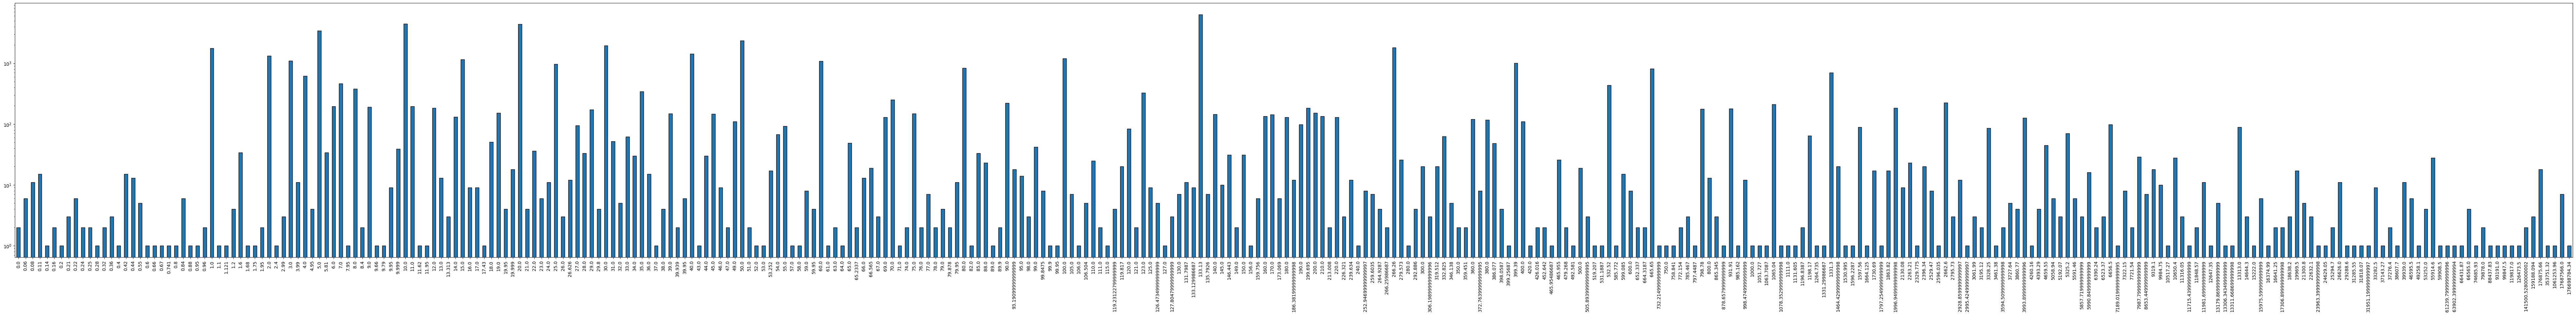

In [9]:
# and with log scale
price_distribution.plot(kind='bar', logy=True, edgecolor='black', figsize=(100, 10))

In [10]:
# high change to see clusters emerging

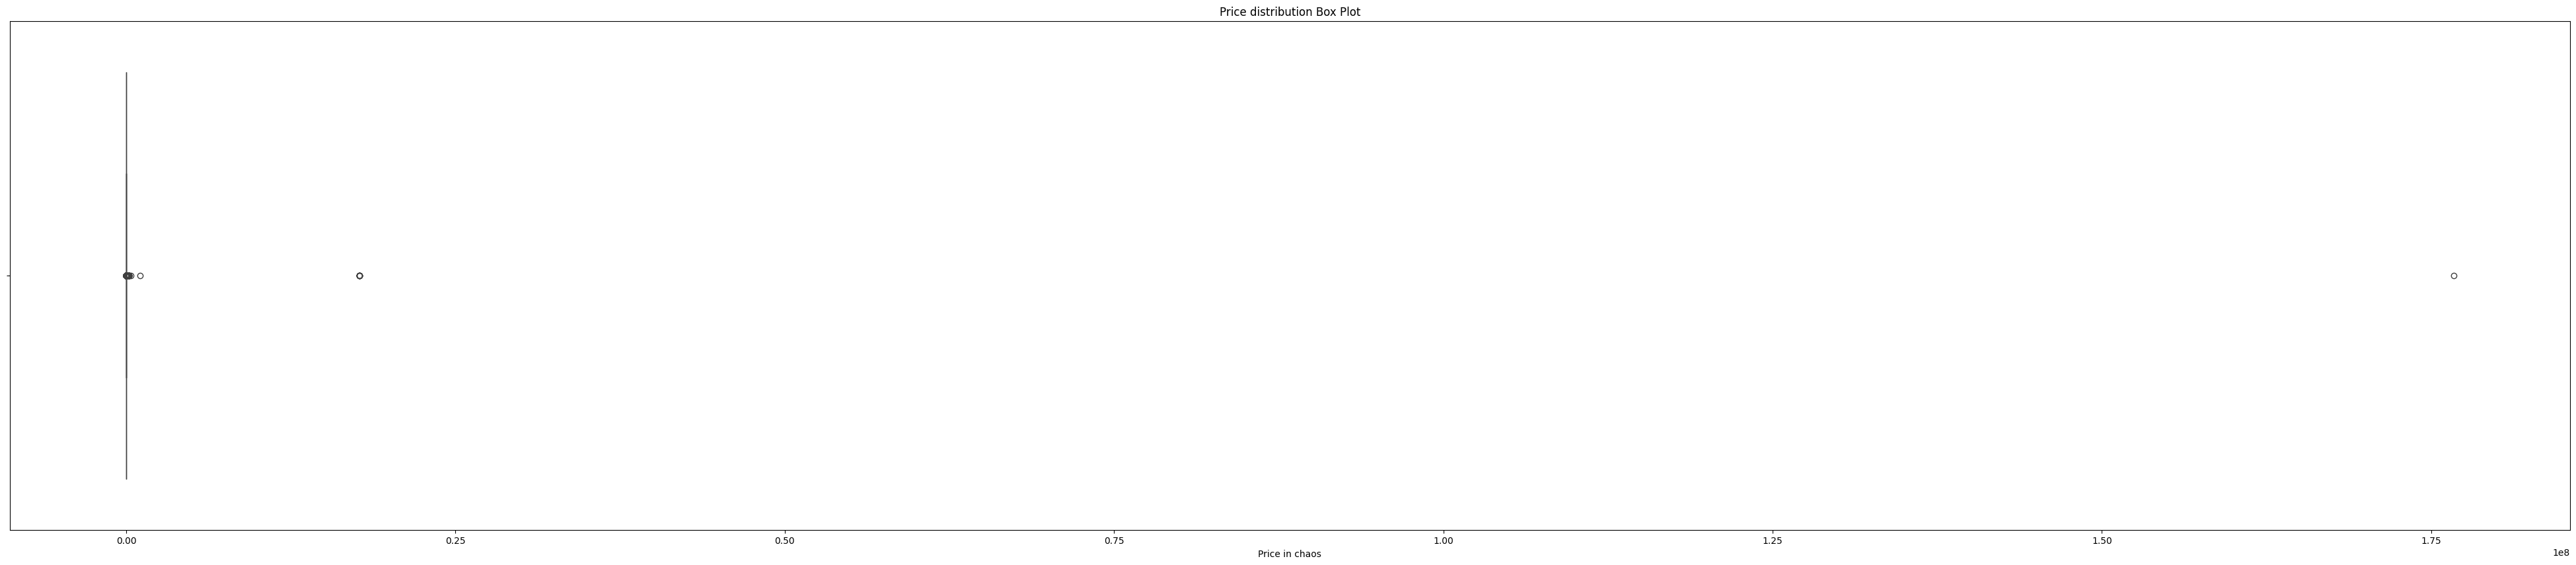

In [11]:
plt.figure(figsize=(50, 10))
sns.boxplot(x=prices)
plt.title("Price distribution Box Plot")
plt.xlabel("Price in chaos")
plt.show()

# Outlier detection

In [12]:
@dataclass
class OutlierResult:
    lower_outliers: list[PriceWithFileName]
    upper_outliers: list[PriceWithFileName]
    not_outliers: list[PriceWithFileName]

    @property
    def outliers(self):
        return self.upper_outliers + self.lower_outliers
    
    @property
    def lower_outliers_names(self):
        return [price_with_file_name.name for price_with_file_name in self.lower_outliers]
    
    @property
    def upper_outliers_names(self):
        return [price_with_file_name.name for price_with_file_name in self.upper_outliers]
    
    @property
    def outliers_names(self):
        return self.upper_outliers_names + self.lower_outliers_names
    
    @property
    def not_outliers_names(self):
        return [price_with_file_name.name for price_with_file_name in self.not_outliers]
    
    def __post_init__(self):
        self.lower_outliers = sorted(self.lower_outliers, key=lambda p: p.price, reverse=True)
        self.upper_outliers = sorted(self.upper_outliers, key=lambda p: p.price, reverse=True)
    
    def __repr__(self) -> str:
        return f"OutlierResult(len lower_outliers={len(self.lower_outliers)}, lne upper_outliers={len(self.upper_outliers)}, len not_outliers={len(self.not_outliers)}, len outliers={len(self.outliers)})"


def outlier_analysis(prices_with_file_name: list[PriceWithFileName]) -> OutlierResult:
    prices_for_outlier_detection = np.array([price_with_file_name.price for price_with_file_name in prices_with_file_name])
    
    quantile_1 = np.percentile(prices_for_outlier_detection, 25)
    quantile_3 = np.percentile(prices_for_outlier_detection, 75)

    inter_quantile_range = quantile_3 - quantile_1
    lower_bound = quantile_1 - 1.5 * inter_quantile_range
    upper_bound = quantile_3 + 1.5 * inter_quantile_range
    
    upper_outliers = [price_with_file_name for price_with_file_name in prices_with_file_name if price_with_file_name.price > upper_bound]
    lower_outliers = [price_with_file_name for price_with_file_name in prices_with_file_name if price_with_file_name.price < lower_bound]
    not_outliers = [prices_with_file_name for prices_with_file_name in prices_with_file_name if lower_bound <= prices_with_file_name.price <= upper_bound]

    return OutlierResult(lower_outliers, upper_outliers, not_outliers)

In [13]:
# thanks to previous analysis, we know that the forth apply of the outliers contains the real outliers
# each iteration (first, second and thrid) can be used to create the clusters

In [14]:
first_outlier_detection = outlier_analysis(prices_with_name)
first_outlier_detection
# the number of outleir is way to high. It might indicate that the data can have a high volatility and sitll be consistent

OutlierResult(len lower_outliers=0, lne upper_outliers=5742, len not_outliers=43065, len outliers=5742)

In [15]:
# since the outliers are so high, let's try once again outlier detection on those outliers
second_outlier_detection = outlier_analysis(first_outlier_detection.upper_outliers)
second_outlier_detection
# the number of outliers looks better. Let's ask our subject matter expert if those data are reasonable

OutlierResult(len lower_outliers=0, lne upper_outliers=788, len not_outliers=4954, len outliers=788)

In [16]:
print(f"highest is {second_outlier_detection.upper_outliers[0].name} with price {second_outlier_detection.upper_outliers[0].price}")
print(f"lowest is {second_outlier_detection.upper_outliers[-1].name} with price {second_outlier_detection.upper_outliers[-1].price}")


highest is 08a14633cd899dbc87d53b3142097917cfbf69bc09361f81f58e308cae7fd817.json with price 176698784.34
lowest is 74025c0bef3560e0aedfe1e3d84db68c4b5307341d8bccee17321808cb0a633d.json with price 3461.38


In [17]:
# the highest price in the outliers is indeed too high to be reasonable and is an outlier
# the lowest price in the outleirs is reasonable and should not be an outlier
# let's try once again outlier detection on the outliers of the ouliers
third_outlier_detection = outlier_analysis(second_outlier_detection.upper_outliers)
third_outlier_detection
# the number of outliers is still looking fine. Let's ask our subject matter expert if those data are reasonable

OutlierResult(len lower_outliers=0, lne upper_outliers=127, len not_outliers=661, len outliers=127)

In [18]:
print(f"highest is {third_outlier_detection.upper_outliers[0].name} with price {third_outlier_detection.upper_outliers[0].price}")
print(f"lowest is {third_outlier_detection.upper_outliers[-1].name} with price {third_outlier_detection.upper_outliers[-1].price}")


highest is 08a14633cd899dbc87d53b3142097917cfbf69bc09361f81f58e308cae7fd817.json with price 176698784.34
lowest is 3b088486f3d8a18459e519243e5cb1d43f8560d7757258a9e38e1239201feb24.json with price 26626.0


In [19]:
# the highest price is still too high and the lowest price is still reasonable
# we will apply outlier detection once again on the outliers of the outliers of the outliers
forth_outlier_detection = outlier_analysis(third_outlier_detection.upper_outliers)
forth_outlier_detection

OutlierResult(len lower_outliers=0, lne upper_outliers=10, len not_outliers=117, len outliers=10)

In [20]:
print(f"highest is {forth_outlier_detection.upper_outliers[0].name} with price {forth_outlier_detection.upper_outliers[0].price}")
print(f"lowest is {forth_outlier_detection.upper_outliers[-1].name} with price {forth_outlier_detection.upper_outliers[-1].price}")


highest is 08a14633cd899dbc87d53b3142097917cfbf69bc09361f81f58e308cae7fd817.json with price 176698784.34
lowest is ee3bc7b002c7a8de9ac71d9e521dce40dae42f4c6c78d629959118cc9f5cbc41.json with price 353751.32


In [21]:
# the lowest price is not reasonable anymore. So we have 10 real outliers in totral

In [22]:
s_tiers_obj = [obj.name for obj in forth_outlier_detection.not_outliers]
s_tiers_obj_with_price = forth_outlier_detection.not_outliers


In [23]:
a_tiers_obj = [obj.name for obj in third_outlier_detection.not_outliers if obj.name not in s_tiers_obj]
a_tiers_obj_with_price = [obj for obj in third_outlier_detection.not_outliers if obj.name in a_tiers_obj]

In [24]:
b_tiers_obj = [obj.name for obj in second_outlier_detection.not_outliers if obj.name not in s_tiers_obj and obj.name not in a_tiers_obj]
b_tiers_obj_with_price = [obj for obj in second_outlier_detection.not_outliers if obj.name in b_tiers_obj]

In [25]:
others_with_prices = first_outlier_detection.not_outliers
others_only_prices = [obj.price for obj in others_with_prices]

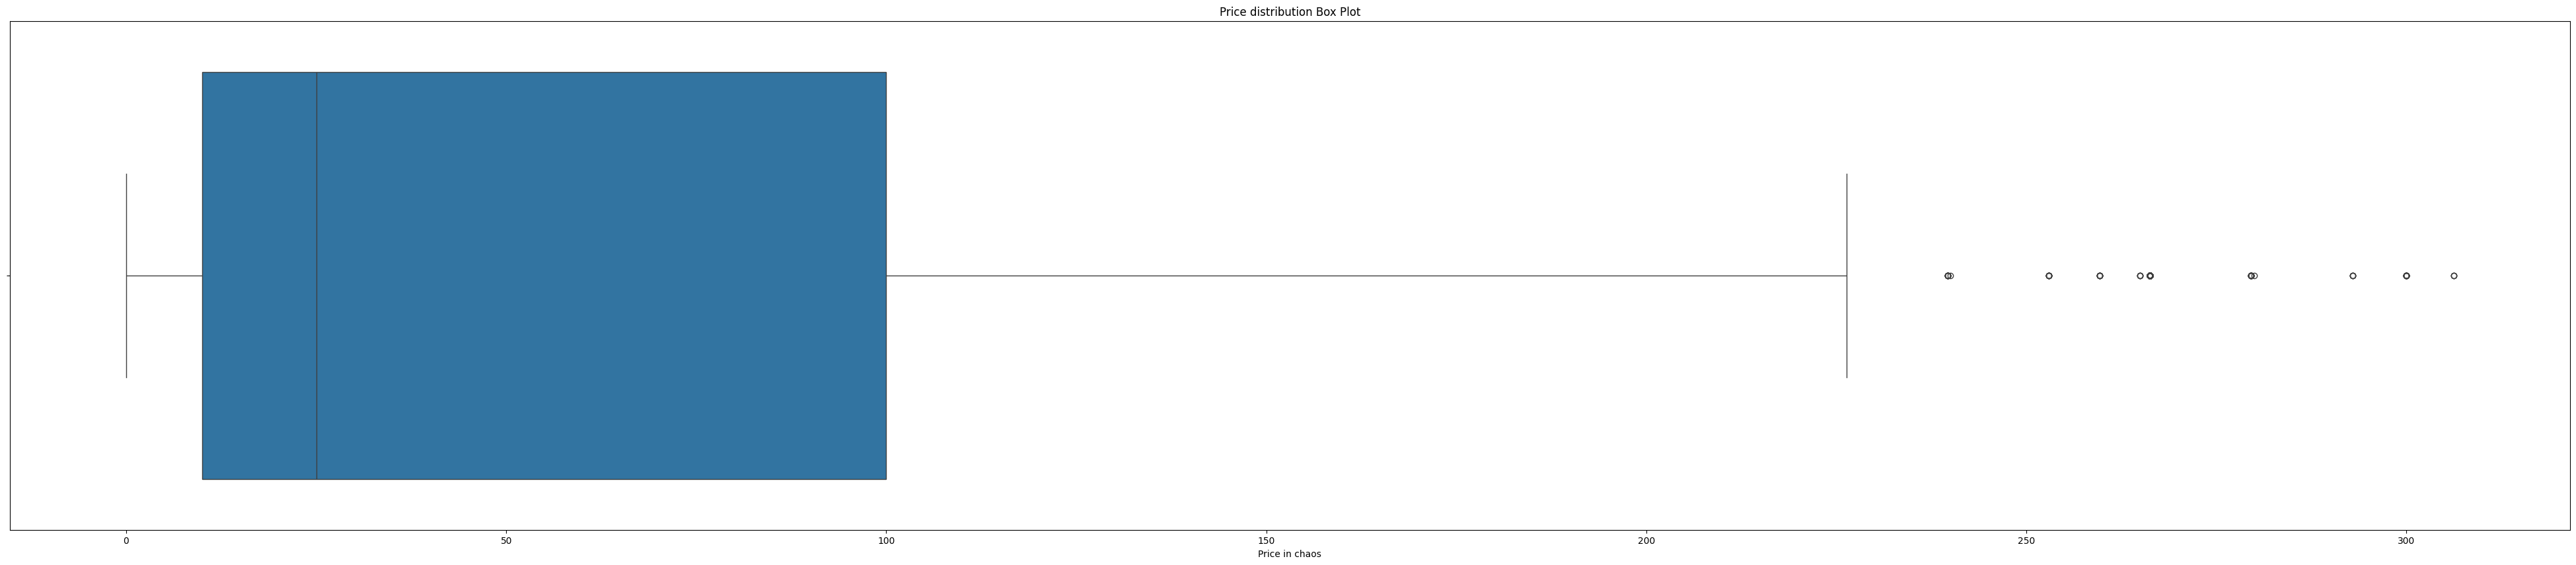

In [26]:
plt.figure(figsize=(50, 10))
sns.boxplot(x=others_only_prices)
plt.title("Price distribution Box Plot")
plt.xlabel("Price in chaos")
plt.show()

# K-Means clustering

In [27]:
# we already have 3 clusters (educated guess based on the outlier analysis,
#  outliers standing out sufficiently to be placed in their own clusers)

In [28]:
prices_array = np.array(others_only_prices).reshape(-1,1)


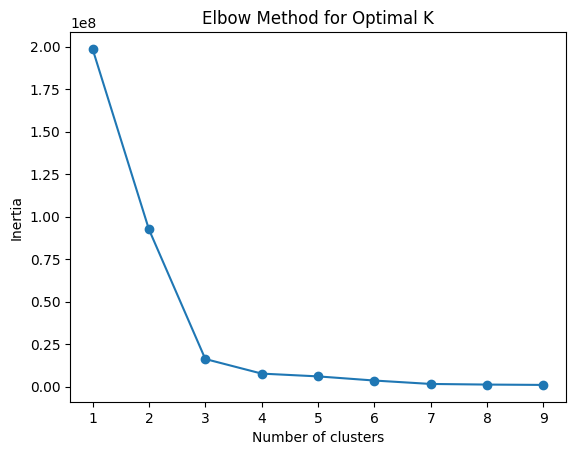

In [29]:
cluster_inertia = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(prices_array)
    cluster_inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), cluster_inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [30]:
# elbow at 3, so 3 clusers can be found in the not outliers ofr the first outlier detection

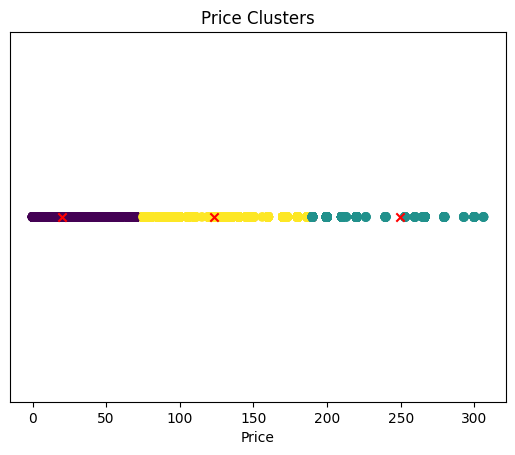

In [31]:
# we assume 3 clusters: C, D, E
kmeans_no_outliers = KMeans(n_clusters=3, random_state=0)
price_clusters = kmeans_no_outliers.fit_predict(prices_array)

price_cluster_centers = kmeans_no_outliers.cluster_centers_ # for visualization

plt.scatter(prices_array, [0]*len(prices_array), c=price_clusters, cmap='viridis', marker='o')
plt.scatter(price_cluster_centers, [0]*len(price_cluster_centers), color='red', marker='x')  # cluster centers
plt.title('Price Clusters')
plt.xlabel('Price')
plt.yticks([])  # no need foy-axis
plt.show()

# K-Means Clustering Extended with Outlier clustering

In [32]:
s_tiers_price_array = np.array([obj.price for obj in s_tiers_obj_with_price]).reshape(-1,1)
s_tiers_kmeans = KMeans(n_clusters=1, random_state=0)
s_tiers_micro_cluster = s_tiers_kmeans.fit_predict(s_tiers_price_array)
s_tiers_micro_cluster_center = s_tiers_kmeans.cluster_centers_

In [33]:
a_tiers_price_array = np.array([obj.price for obj in a_tiers_obj_with_price]).reshape(-1,1)
a_tiers_kmeans = KMeans(n_clusters=1, random_state=0)
a_tiers_micro_cluster = a_tiers_kmeans.fit_predict(a_tiers_price_array)
a_tiers_micro_cluster_center = a_tiers_kmeans.cluster_centers_

In [34]:
b_tiers_price_array = np.array([obj.price for obj in b_tiers_obj_with_price]).reshape(-1,1)
b_tiers_kmeans = KMeans(n_clusters=1, random_state=0)
b_tiers_micro_cluster = b_tiers_kmeans.fit_predict(b_tiers_price_array)
b_tiers_micro_cluster_center = b_tiers_kmeans.cluster_centers_

In [35]:
all_kmeans_centers = np.concatenate((price_cluster_centers, b_tiers_micro_cluster_center, a_tiers_micro_cluster_center, s_tiers_micro_cluster_center))
all_kmeans_centers

array([[2.01882892e+01],
       [2.49773503e+02],
       [1.23467143e+02],
       [9.47579173e+02],
       [8.14777339e+03],
       [7.38301807e+04]])

In [36]:
all_clusters = np.concatenate((price_clusters, 3+b_tiers_micro_cluster, 4+a_tiers_micro_cluster, 5+s_tiers_micro_cluster))
all_clusters

array([0, 0, 2, ..., 5, 5, 5], dtype=int32)

In [37]:
all_prices_array = np.concatenate((prices_array, b_tiers_price_array, a_tiers_price_array, s_tiers_price_array))
all_prices_array

array([[   30.],
       [   50.],
       [   80.],
       ...,
       [26626.],
       [26626.],
       [26626.]])

In [38]:
# how many data per cluster
all_clusters_serie = pd.Series(all_clusters)
all_clusters_distribution = all_clusters_serie.value_counts().sort_index()
all_clusters_distribution

0    30359
1     2601
2    10105
3     4954
4      661
5      117
Name: count, dtype: int64

In [39]:
# note, thanks to the clusters centers analysed previously, we know that, in
# this representation, the order of the cluster is 0, 2, 1, 3, 4, 5 (1 and 2 are inverted)
# kmenas doesn't care about the order of the cluster... a cluster is a cluster.
# We only expect an order bsed on their cluster centers that should increase

# so the number or item per cluster is (in the correct order)
# 0 = e => 30359
# 2 = d => 10105
# 1 = c => 2601
# 3 = b => 4954
# 4 = a => 661
# 5 = s => 117

# it's a little sad the number of item in cluster c is lower than cluster b.
# this is due to the shift in cluster detection with outlier based inference.
# But this is not really impactedful for the expected model since we are more
# interested in evaluating s, a and b (where the eral value is) and we don't
# really need a high accurency for below clusters.

# only drawback if the model is extensifely used, we will see a lower pricing
# in the c range since there will be less chance of seeing thos as accuratly
# detected by the model.

# if this is bcoming a concern in the future, we can create three models:
# the first one taking care of non outliers data (c, d, e), and another one
# for the outlier ones. The last one will be there to determine if the object
# is in the lower tiers, or the upper tiers.

In [40]:
tiers_center_distribution_tuples = [
    (tier, *center, count) 
    for tier, center, count 
    in zip(
        [0, 2, 1, 3, 4, 5], 
        all_kmeans_centers.tolist(),
        all_clusters_distribution.to_list()
    )]
tiers_center_distribution_tuples

[(0, 20.188289153137767, 30359),
 (2, 249.77350289647597, 2601),
 (1, 123.4671431560795, 10105),
 (3, 947.5791731941274, 4954),
 (4, 8147.773392133125, 661),
 (5, 73830.18066666667, 117)]

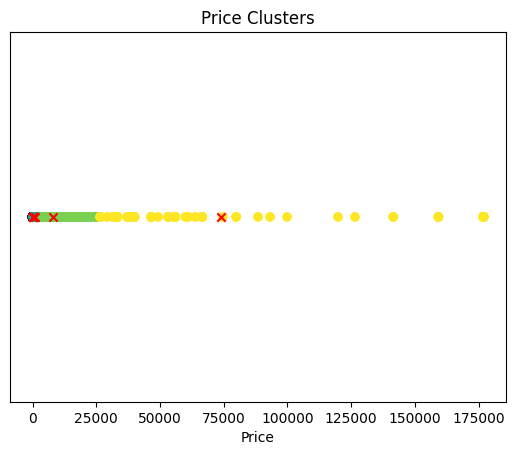

In [41]:
plt.scatter(all_prices_array, [0]*len(all_prices_array), c=all_clusters, cmap='viridis', marker='o')
plt.scatter(all_kmeans_centers, [0]*len(all_kmeans_centers), color='red', marker='x')
plt.title('Price Clusters')
plt.xlabel('Price')
plt.yticks([])
plt.show()

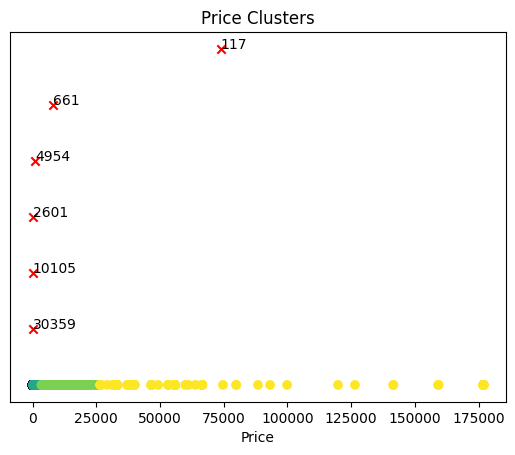

In [42]:
# not quite visual since the 3 outliers cluster have so much disparities that they mask the standarts kmeans nased clusters
# let's plot the centers at different levels to realize the final clusters
plt.scatter(all_prices_array, [0]*len(all_prices_array), c=all_clusters, cmap='viridis', marker='o')

# this weird order is by construct when merging all the clustes information together
plt.scatter(all_kmeans_centers, [1, 3, 2, 4, 5, 6], color='red', marker='x')
plt.title('Price Clusters')
plt.xlabel('Price')
plt.yticks([])

for tp in tiers_center_distribution_tuples:
    plt.annotate(f'{tp[2]}', (tp[1], tp[0]+1))

plt.show()

# From JSON to List transformation

In [43]:
rarities_token = set()
sockets_token = set()
valuated_stats_token = set()

for file in os.listdir(SAMPLE_DIR):
    if file.endswith(".json"):
        with open(os.path.join(SAMPLE_DIR, file), 'r') as f:
            data = json.load(f)
            rarities_token.add(data['rarity'])
            sockets_token.add(data['socket']) 
            valuated_stats_token.update({stat['id'] for stat in data['valuatedStats']})


In [44]:
rarities_token

{'Magic', 'Normal', 'Rare'}

In [45]:
sockets_token

{'A', 'B', 'G', 'N', 'R', 'W'}

In [46]:
len(valuated_stats_token)

875

In [47]:
BASIC_FILE = "0a0a5c89a084f5bceff3b83618846d57b03c6ee5d0758ac31f9a957ccf4ff66e.json"

with open(os.path.join(SAMPLE_DIR, BASIC_FILE), "r") as f:
    obj_sample_1 = json.load(f)
obj_sample_ids_valuated_stats = [i['id'] for i in obj_sample_1["valuatedStats"]]
len(obj_sample_ids_valuated_stats)

874

In [48]:
next(i for i in valuated_stats_token if i not in obj_sample_ids_valuated_stats)

'onslaught_time_granted_on_kill_ms'

In [49]:
def _from_boolean_to_list(value: bool | None) -> List[int]:
    if value is None:
        return [0, 0]
    return [1, 0] if value else [0, 1]

In [50]:
def rarity_to_list(data) -> List[int]:
    rarity = data.get('rarity', 'Unknown')
    if rarity == "Normal":
        return [1, 0, 0]
    elif rarity == "Magic":
        return [0, 1, 0]
    elif rarity == "Rare":
        return [0, 0, 1]
    else:
        return [0, 0, 0]

In [51]:
def socker_to_list(data) -> List[int]:
    socket = data.get('socket', 'Unknown')
    if socket == 'N':
        return [1, 0, 0, 0, 0, 0]
    elif socket == 'A':
        return [0, 1, 0, 0, 0, 0]
    elif socket == 'B':
        return [0, 0, 1, 0, 0, 0]
    elif socket == 'R':
        return [0, 0, 0, 1, 0, 0]
    elif socket == 'G':
        return [0, 0, 0, 0, 1, 0]
    elif socket == 'W':
        return [0, 0, 0, 0, 0, 1]
    else:
        return [0, 0, 0, 0, 0, 0]

In [52]:

# for the valuatedStats, we will need the final list of string exported so that we can use it in out dockerized model exposition
# so we will go through a jinja template to generate the function that will be used here
# and for the exposed model
import jinja2

valuated_stats_token_sroted = sorted(valuated_stats_token)

valuated_stats_to_list_template = """from typing import List

def valuated_stats_to_list(data) -> List[float]:
    valuated_stats = data.get('valuatedStats', [])
    valuated_stats_dict = {stat['id']: stat['value'] for stat in valuated_stats}
    return [
    {% for i in valuated_stats_token_sroted %}    valuated_stats_dict.get("{{ i }}", 0.0),
    {% endfor %}]
"""

jinja_env = jinja2.Environment(loader=jinja2.BaseLoader())
jinja_template = jinja_env.from_string(valuated_stats_to_list_template)
jinja2_template_rendered = jinja_template.render(valuated_stats_token_sroted=valuated_stats_token_sroted)

with open("valuated_stats_to_list.py", "w") as f:
    f.write(jinja2_template_rendered)

In [53]:
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
import os, sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
from valuated_stats_to_list import valuated_stats_to_list

valuated_stats_to_list(obj_sample_1)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 13.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 48.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 54.0,
 0.0,
 45.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


In [54]:
def identified_to_list(data) -> List[int]:
    return _from_boolean_to_list(data.get('identified', None))

def influences_to_list(data) -> List[int]:
    influences = data.get('influences', {})
    return _from_boolean_to_list(influences.get('warlord', None)) + \
        _from_boolean_to_list(influences.get('elder', None)) + \
        _from_boolean_to_list(influences.get('shaper', None)) + \
        _from_boolean_to_list(influences.get('crusader', None)) + \
        _from_boolean_to_list(influences.get('redeemer', None)) + \
        _from_boolean_to_list(influences.get('hunter', None))

def fractured_to_list(data) -> List[int]:
    return _from_boolean_to_list(data.get('fractured', None))

def synthesised_to_list(data) -> List[int]:
    return _from_boolean_to_list(data.get('synthesised', None))

def duplicated_to_list(data) -> List[int]:
    return _from_boolean_to_list(data.get('duplicated', None))

def split_to_list(data) -> List[int]:
    return _from_boolean_to_list(data.get('split', None))

def corrupted_to_list(data) -> List[int]:
    return _from_boolean_to_list(data.get('corrupted', None))

def qualities_to_list(data) -> List[int]:
    quality = data.get('qualities', {})
    return [
        quality.get('attack', 0),
        quality.get('attribute', 0),
        quality.get('caster', 0),
        quality.get('critical', 0),
        quality.get('defense', 0),
        quality.get('elemental', 0),
        quality.get('lifeAndMana', 0),
        quality.get('physicalAndChaos', 0),
        quality.get('resistance', 0),
        quality.get('speed', 0),
    ]


In [55]:
def from_json_repr_to_list(data) -> List[int]:
    return rarity_to_list(data) + \
        [data.get('ilvl', 0)] + \
        identified_to_list(data) + \
        [data.get('levelRequirement', 0)] + \
        socker_to_list(data) + \
        influences_to_list(data) + \
        fractured_to_list(data) + \
        synthesised_to_list(data) + \
        duplicated_to_list(data) + \
        split_to_list(data) + \
        corrupted_to_list(data) + \
        qualities_to_list(data) + \
        valuated_stats_to_list(data)
        

# Building CSV data (without category)

In [56]:
base_object_reference = from_json_repr_to_list(obj_sample_1)
base_object_reference

[0,
 0,
 1,
 84,
 1,
 0,
 67,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 20,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 13.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 48.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

In [57]:
columns = ['object_id'] + [f'feature_{i}' for i in range(len(base_object_reference))]


In [58]:
forth_outlier_detection.upper_outliers_names

['08a14633cd899dbc87d53b3142097917cfbf69bc09361f81f58e308cae7fd817.json',
 '91e023418050dc1f4873401685fb7c63d4732927aa178791cb983627a0045d76.json',
 '9f927d84899fd5b7528feb0dd99e33f67bcc81ec19c1cb40a735ff1c482eb952.json',
 'e464f9e00e60dd2d7bb828760cfdc476710c2855b0835a8385160b5fc4025445.json',
 '3523c239fd8bf20f996781d63089e545f3d28cf0f03e8f3c1f67257bf5c732fe.json',
 '7f16d2cf552ae9eb5617a61bf534d05b66c8c6de787179323ee26332d89fca21.json',
 '99a1c45654c8131ade3c216f386d227a3ffb51d5f12e079143b493be576d2516.json',
 'e91420d78192fd1c96b5392d97594936a2c5ad7070221711fb554d186a656e35.json',
 '8bf3b2caee846a6bed9613ac53d80537e1ecb2ba32b07a7519e4c9608eacafa5.json',
 'ee3bc7b002c7a8de9ac71d9e521dce40dae42f4c6c78d629959118cc9f5cbc41.json']

In [59]:
# it can take a while to process all the data
# on my machine, it take between 70 and 150 minutes (depends its mood).
# So I put a control flow to only process the json file if I don't already have the final CSV files. If so, only load the pre
# build csv instead of rebuilding the whole dataframe from the json files.
SKIP_JSON_PROCESS_AND_USE_CSV_FILE = False
csv_files = [f for f in os.listdir("transformed_data") if re.match(r'50k_transformed_data_no_category_[0-9]*_of_[0-9]*\.csv', f)]

df_data_no_category = None


if SKIP_JSON_PROCESS_AND_USE_CSV_FILE and csv_files:
    dfs = []
    csv_files = [f for f in os.listdir("transformed_data") if re.match(r'50k_transformed_data_no_category_[0-9]*_of_[0-9]*\.csv', f)]
    for g in csv_files:
        dfs.append(pd.read_csv(os.path.join("transformed_data", g)))
    df_data_no_category = pd.concat(dfs)
else:

    df_data_no_category = pd.DataFrame(columns=columns) 

    control_length = len(base_object_reference)

    step = 0
    total = len(first_outlier_detection.not_outliers + first_outlier_detection.upper_outliers) - len(forth_outlier_detection.outliers)

    for file in os.listdir(SAMPLE_DIR):
        if file.endswith(".json") and file.removeprefix(".json") not in forth_outlier_detection.outliers_names:
            with open(os.path.join(SAMPLE_DIR, file), 'r') as f:
                step += 1
                if step % 500 == 0:
                    print(f"step {step}/{total}")   

                data = json.load(f)
                row = [data["id"]] + from_json_repr_to_list(data)
                if len(row)-1 != control_length:
                    print(f"error with {file}. Expected {control_length} got {len(row)-1} at iteration {step}")
                else:
                    df_data_no_category.loc[len(df_data_no_category)] = row

step 500/48797
step 1000/48797
step 1500/48797
step 2000/48797
step 2500/48797
step 3000/48797
step 3500/48797
step 4000/48797
step 4500/48797
step 5000/48797
step 5500/48797
step 6000/48797
step 6500/48797
step 7000/48797
step 7500/48797
step 8000/48797
step 8500/48797
step 9000/48797
step 9500/48797
step 10000/48797
step 10500/48797
step 11000/48797
step 11500/48797
step 12000/48797
step 12500/48797
step 13000/48797
step 13500/48797
step 14000/48797
step 14500/48797
step 15000/48797
step 15500/48797
step 16000/48797
step 16500/48797
step 17000/48797
step 17500/48797
step 18000/48797
step 18500/48797
step 19000/48797
step 19500/48797
step 20000/48797
step 20500/48797
step 21000/48797
step 21500/48797
step 22000/48797
step 22500/48797
step 23000/48797
step 23500/48797
step 24000/48797
step 24500/48797
step 25000/48797
step 25500/48797
step 26000/48797
step 26500/48797
step 27000/48797
step 27500/48797
step 28000/48797
step 28500/48797
step 29000/48797
step 29500/48797
step 30000/48797


In [62]:
# based on previous experiment, if I print the dataframe into a CSV in one block,
# the file will exceed 300 Mb, which is small for a csv, but too big for github...
# at commiting one of them wrongly messed up my previous repo (unable to push multiple commits),
# and had to restart the git context from sratch to exclude such files. 

# So I will split the dataframe into multiple files to avoid this issue
SHOULD_OVERRIDE_FILES = False

number_of_row_per_file = 10000
number_of_file = len(df_data_no_category) // number_of_row_per_file + 1


os.makedirs("transformed_data", exist_ok=True)
csv_files = [f for f in os.listdir("transformed_data") if re.match(r'50k_transformed_data_no_category_[0-9]*_of_[0-9]*\.csv', f)]

if not csv_files or SHOULD_OVERRIDE_FILES:
    for f in csv_files:
        os.remove(os.path.join("transformed_data", f))
    for i, chunk in enumerate(np.array_split(df_data_no_category, number_of_file)):
        chunk.to_csv(os.path.join("transformed_data", f"50k_transformed_data_no_category_{i+1}_of_{number_of_file}.csv"), index=False)

# Building CSV Data (with category)

In [66]:
@dataclass
class ClusterWithFileName:
    cluster: int
    name: str

    @property
    def category(self) -> str:
        if self.cluster == 0:
            return "e"
        elif self.cluster == 2:
            return "c"
        elif self.cluster == 1:
            return "d"
        elif self.cluster == 3:
            return "b"
        elif self.cluster == 4:
            return "a"
        elif self.cluster == 5:
            return "s"
        else:
            return "Unknown"

In [72]:
# clusters category by price, c,d,e clusters
file_name_with_cluster_c_d_e = [ClusterWithFileName(int(cluster), name.name) for cluster, name in zip(price_clusters, others_with_prices)]
file_name_with_cluster_c_d_e

[ClusterWithFileName(cluster=0, name='015d9b353acb20db3cdbc05f1386aab18cd5166d9b0bdd26fae7e163ef29786a.json'),
 ClusterWithFileName(cluster=0, name='b3533b5e5ae6e2bd6d0f7bcca2239e78c4c422f84324fe091021fcdf68c0ff7c.json'),
 ClusterWithFileName(cluster=2, name='7a70ed1d8643800ae1e2e596db3af8a9a9e5a32b2297ec99ed8e9ccf1690c641.json'),
 ClusterWithFileName(cluster=0, name='a19cac5720bd4f47228521419907354dd0e5420ae01a00a054d84cd00a1f0d36.json'),
 ClusterWithFileName(cluster=0, name='34c782d6ab2f88fc0b45dd2bfcd5db2edd65e5b00a588ba5910f553e6bf61da3.json'),
 ClusterWithFileName(cluster=0, name='a3dc2bb31ef0723980ab180fc46a6cca475e530b4efc352982e2190c44648d41.json'),
 ClusterWithFileName(cluster=2, name='32b4a72c6b5e0e9cb5397af90e17d3fb3a01c5530131539c58c0efb2d5aa2af9.json'),
 ClusterWithFileName(cluster=2, name='def17fb9ac6ad54fefca12d4f4b0c6646980e137f8077558f6815f4344c2193a.json'),
 ClusterWithFileName(cluster=0, name='00a6d4fcd3e33067c0182262465e76ea19869cf63c3fc911f22de11b176d058f.json'),
 

In [75]:
file_name_with_cluster_s_a_b = [ClusterWithFileName(5, name) for name in s_tiers_obj] + [ClusterWithFileName(4, name) for name in a_tiers_obj] + [ClusterWithFileName(3, name) for name in b_tiers_obj]
file_name_with_cluster_s_a_b

[ClusterWithFileName(cluster=5, name='aac5b9cb2f18177fa3108db57be5b5ad63af3da19bd61a4452136d0aff3859f0.json'),
 ClusterWithFileName(cluster=5, name='4a442c51ad925642dc8dba051f929c6e3be8b2468fc614087612e51619f81bc4.json'),
 ClusterWithFileName(cluster=5, name='7e06dd1f015d25777595c18a99ea347e498f82f6822af001d743418bba8eca48.json'),
 ClusterWithFileName(cluster=5, name='7f275ed44eb0f6297e1a4b7ed1eb9208f120a4831f3801d0845627e576df2df3.json'),
 ClusterWithFileName(cluster=5, name='f4aa9c0a4a48c9c82fbb5411a46ce3e0b5d96bb4ad91dbefb95f9063e2d8c25f.json'),
 ClusterWithFileName(cluster=5, name='c13b6171a206df5b081cf8e045e062977eff52835eae6dc62d3bcb234619b031.json'),
 ClusterWithFileName(cluster=5, name='8ac2c09a29b4d087b2d18c9b6e576188f9ad8faf55c5ced523816b7cdd42cd69.json'),
 ClusterWithFileName(cluster=5, name='1779fbea8a709d854b247ec49c7f1c3013d2937f0b3b65545c1736b3831f49ec.json'),
 ClusterWithFileName(cluster=5, name='9240984860149f418d47242cace386a4a1ec56e1b4a3b0363a70c0a9a70b80df.json'),
 

In [83]:
file_name_with_cluster_s_a_b_c_d_e = file_name_with_cluster_s_a_b + file_name_with_cluster_c_d_e
cluster_map_s_a_b_c_d_e = {element.name.removesuffix(".json"): element.category for element in file_name_with_cluster_s_a_b_c_d_e}
cluster_map_s_a_b_c_d_e


{'aac5b9cb2f18177fa3108db57be5b5ad63af3da19bd61a4452136d0aff3859f0': 's',
 '4a442c51ad925642dc8dba051f929c6e3be8b2468fc614087612e51619f81bc4': 's',
 '7e06dd1f015d25777595c18a99ea347e498f82f6822af001d743418bba8eca48': 's',
 '7f275ed44eb0f6297e1a4b7ed1eb9208f120a4831f3801d0845627e576df2df3': 's',
 'f4aa9c0a4a48c9c82fbb5411a46ce3e0b5d96bb4ad91dbefb95f9063e2d8c25f': 's',
 'c13b6171a206df5b081cf8e045e062977eff52835eae6dc62d3bcb234619b031': 's',
 '8ac2c09a29b4d087b2d18c9b6e576188f9ad8faf55c5ced523816b7cdd42cd69': 's',
 '1779fbea8a709d854b247ec49c7f1c3013d2937f0b3b65545c1736b3831f49ec': 's',
 '9240984860149f418d47242cace386a4a1ec56e1b4a3b0363a70c0a9a70b80df': 's',
 'e969a094698c167bf7163f924dd1b2be70fb6d826310312a8e4d61952bdad25c': 's',
 '0577919239e98a8796cd0a1526150e647fdb7ff9c394b02ae63443c273b545db': 's',
 'c834dce02656165a9a3ce3f25996ca3e705078283f1684408085d8a6719d115b': 's',
 'c0a7a13a4bf9a4847e992b3dcc1abdaa91afd57f78cf4842796ac2594fff1015': 's',
 'ad6562d508f3c78989ff30780f3b6382655a

In [79]:
def tier_category_to_list(category: int) -> List[int]:
    if category == 's':
        return [1, 0, 0, 0, 0, 0]
    elif category == 'a':
        return [0, 1, 0, 0, 0, 0]
    elif category == 'b':
        return [0, 0, 1, 0, 0, 0]
    elif category == 'c':
        return [0, 0, 0, 1, 0, 0]
    elif category == 'd':
        return [0, 0, 0, 0, 1, 0]
    elif category == 'e':
        return [0, 0, 0, 0, 0, 1]
    else:
        return [0, 0, 0, 0, 0, 0]

In [81]:
df_data_no_category.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48797 entries, 0 to 48796
Columns: 921 entries, object_id to feature_919
dtypes: float64(875), int64(45), object(1)
memory usage: 343.3+ MB


In [86]:
# the memory usage is around 350 Mb which is reasonable and way less than expected
# so we can simply create a new one to add the category column and vector
df_data_with_category= None

def category_columns_for_name(name: str):
    category = cluster_map_s_a_b_c_d_e.get(name, 'unknown')
    return [category] + tier_category_to_list(category)

category_colums = df_data_no_category['object_id'].apply(category_columns_for_name).apply(pd.Series)
category_colums.columns = ['category'] + [f'category_{i}' for i in range(6)]

df_data_with_category = pd.concat([df_data_no_category, category_colums], axis=1)
# no need to add a control to bypass the creation of the dataframe since it runs below 10 seconds

In [91]:
df_data_with_category

,object_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_917,feature_918,feature_919,category,category_0,category_1,category_2,category_3,category_4,category_5
0,015d9b353acb20db3cdbc05f1386aab18cd5166d9b0bdd...,0,0,1,76,1,0,35,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1
1,b3533b5e5ae6e2bd6d0f7bcca2239e78c4c422f84324fe...,0,0,1,82,1,0,57,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1
2,7a70ed1d8643800ae1e2e596db3af8a9a9e5a32b2297ec...,0,0,1,85,1,0,64,1,0,...,0.0,0.0,0.0,c,0,0,0,1,0,0
3,a19cac5720bd4f47228521419907354dd0e5420ae01a00...,0,0,1,83,1,0,59,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1
4,34c782d6ab2f88fc0b45dd2bfcd5db2edd65e5b00a588b...,0,0,1,83,1,0,44,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48792,439741f41e730850be431fd18738fd7b4a882be879bbd5...,0,0,1,71,1,0,54,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1
48793,15952201ee3ccaaa0c4125887708d20b1d9c85015b81f9...,0,0,1,83,1,0,57,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1
48794,8b9435a86f12d755156d8c45ee8f82a437bbfad2a4e3dc...,0,0,1,85,1,0,67,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1
48795,96dd1a045f096d9a4244b98bf0c8b7c2744fb4e11502c9...,0,0,1,72,1,0,44,1,0,...,0.0,0.0,0.0,e,0,0,0,0,0,1


In [89]:
csv_files_with_category = [f for f in os.listdir("transformed_data") if re.match(r'50k_transformed_data_with_category_[0-9]*_of_[0-9]*\.csv', f)]

if not csv_files_with_category or SHOULD_OVERRIDE_FILES:
    for f in csv_files_with_category:
        os.remove(os.path.join("transformed_data", f))
    for i, chunk in enumerate(np.array_split(df_data_with_category, number_of_file)):
        chunk.to_csv(os.path.join("transformed_data", f"50k_transformed_data_with_category_{i+1}_of_{number_of_file}.csv"), index=False)

/home/ludovic/Dev/Leddzip/Projects/poe-model/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [92]:
# only there to skip previous steps and directly load teh data for model training or additional analyis.
# no additional anaylsis expected for now but it's always good to have the data ready for further analysis especially if it's such a pain to reach this step
# and to avoid useless distraction when a new idea arise.
if df_data_with_category is None:
    dfs = []
    csv_files_with_category = [f for f in os.listdir("transformed_data") if re.match(r'50k_transformed_data_with_category_[0-9]*_of_[0-9]*\.csv', f)]
    for g in csv_files_with_category:
        dfs.append(pd.read_csv(os.path.join("transformed_data", g)))
    df_data_with_category = pd.concat(dfs)